In [1]:
import pandas as pd
import numpy as np
import spacy
from bert_serving.client import BertClient
from sklearn.metrics import jaccard_similarity_score
from nltk.metrics import masi_distance
import string
import textdistance
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
glove_300 = api.load("glove-wiki-gigaword-300")
#glove_300.save_word2vec_format('glove.6B.300d.txt')
lemmer = nltk.stem.WordNetLemmatizer()
nltk.download('punkt')
def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))
#Normalizing sentence vectors with TFIDF
def tfidf(question,context):
    concat=[]
    concat.append(question)
    concat.append(context)
    #print(concat)
    TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')
    tfidf = TfidfVec.fit_transform(concat)
    vals = cosine_similarity(tfidf[-1], tfidf)
    #print(vals)
    idx=vals.argsort()[0][-2]
    flat = vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    #print(req_tfidf)
    return req_tfidf
#Function for Jaccard similarity
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union
#datasize=250
nlp = spacy.load("en_core_web_sm")
question_words=["what","which","who","whom","whoose","when","where","whence","why","how","?"]
df=pd.read_csv('WikiQA-train.tsv',sep='\t')
#print(Counter(df.iloc[:,-1]))
test1=df[df['Label']==1]
test1=test1.iloc[:1000]
test2=df[df['Label']==0]
test2=test2.iloc[:1000]
#print(test2)
df=pd.concat([test1,test2],axis=0)
#test.to_csv('C:\\Users\\Pritam\\Desktop\\WikiQACorpus\\test.csv')
#df=df.iloc[:500]
#x_train, x_test, y_train, y_test = train_test_split( df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=42)
result=list()
qid=''
temp=list()
pred=list()
cosine=[]
lav_dis=[]
jac_sim=[]
mscore=[]
ham_dis=[]
jwscore=[]
sdscore=[]
roscore=[]
escore=[]
wmd=[]
ner_feature=[]
common_keywords=[]
count_noun_chunks=[]
tfidf_cosine=[]
for row in range(0,len(df)-1):
    #j=tokenise()
    #print(row)
    #concat_list=[]
    if row==0:
        qid=df.iloc[row]['QuestionID']

    #t=list()
    ques=df.iloc[row]['Question'].lower() #obtaining data from the dataset row wise
    my_doc = nlp(df.iloc[row]['Question'].lower())
    context=df.iloc[row]['Sentence'].lower()
    #concat_list.append(ques)
    #concat_list.append(context)

    token_list = []    #Creating  token list
    for token in my_doc:
        token_list.append(token.text) 
    sen=""
    for word in token_list:  #Removing question words and symbol and reformulating
        if word.lower() not in question_words:
            sen=sen+word+" "
    ques=sen
    tfidf_cos=tfidf(ques,context) #Measuring various distance based metrics
    tfidf_cosine.append(tfidf_cos)
    q_ner=list()
    doc1=nlp(sen)
    for ent in doc1.ents:    #obtaining NER from question
        q_ner.append(ent.text)
    
    doc2=nlp(context)
    ner_count=0
    for ent in doc2.ents:     #obtaining NER from context
            ner_count=ner_count+1
    ner_feature.append(ner_count)
    keycount=0
    rootq = [token for token in doc1 if token.head == token][0]  #Root word in dependency parsing of the question
    #only taking noun/verb/proper noun as important key words
    keywordsq=[t.text for t in rootq.subtree if t.pos_=="NOUN" or t.pos_=="PROPN" or t.pos_=="VERB" or t.pos_=="NUM"]
    rootc = [token for token in doc2 if token.head == token][0]  #Root word of the context
    keywordsc=[t.text for t in rootc.subtree if t.pos_=="NOUN" or t.pos_=="PROPN" or t.pos_=="VERB" or t.pos_=="NUM"]
    for key in keywordsq:
        if key in keywordsc:
            keycount=keycount+1
    common_keywords.append(keycount)
    #ner_feature.append(ner_count)
    q_noun_chunks=list(doc1.noun_chunks)  #noun chunks in sentences
    c_noun_chunks=list(doc2.noun_chunks)
    count_chunks=0
    for chunk in c_noun_chunks:    #validate common noun chunks
        if chunk in q_noun_chunks:
            count_chunks=count_chunks+1
    count_noun_chunks.append(count_chunks)
    bc = BertClient(check_length=False)  #Bert client object
    question_vec = bc.encode([sen])[0]  #encoding with bert as service
    c_vec=bc.encode([context])
    score=np.sum(question_vec * c_vec, axis=1) / np.linalg.norm(c_vec, axis=1)  #cosine similarity
    cosine.append(score[0])
    #cosine.append(0)
    temp=glove_300.wmdistance(ques,context)   #Word Movers Distance on GLOVE 300
    if np.isnan(temp)==False:
        temp=0.0
    wmd.append(temp)   
    lav_dis.append(nltk.edit_distance(ques,context)) #Lavenstein Distance
    jac_sim.append(jaccard_similarity(ques.split(),context.split())) #Jaccard
    #jscore=jaccard_similarity(question_vec,c_vec.flatten())
    mscore.append(masi_distance(set(ques.split()),set(context.split()))) #MASI
    ham_dis.append(textdistance.hamming(ques, context)) #HAMMING Distance
    jwscore.append(textdistance.jaro_winkler(ques,context)) #Jaro-winkler distance
    #Sorensen-Dice
    sdscore.append(textdistance.sorensen(ques.split() , context.split())) #Sorensen-Dice
    #Ratcliff-Obershelp similarity
    roscore.append(textdistance.ratcliff_obershelp(ques,context)) #Ratcliff-Obershelp_similarity
    escore.append(textdistance.entropy_ncd(ques,context))  #entropy
    
    #print(c_vec.flatten().shape)
    #print(question_vec.shape)
    #print(cosine)
    
#print(len(lav_dis))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pritam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
featureset = pd.DataFrame(list(zip(cosine,lav_dis,jac_sim,mscore,ham_dis,jwscore,sdscore,roscore,escore,ner_feature,count_noun_chunks,common_keywords,wmd,tfidf_cosine,df.iloc[:,-1])), 
               columns =["Cosine_Similarity","Levenshtein_distance","Jaccard_similarity","Masi_distance","Hamming_dustance","JaroWinkler_socre","Sorensen-Dice","Ratcliff-Obershelp_similarity","NCD_entropy","Common_NER","Common_noun_chunks","Common_Keywords","Word-Movers Distance","Tfidf_Cosine_Similarity","Label"])
print(featureset)
#construction of featureset
featureset.to_csv('C:\\Users\\Pritam\\Desktop\\WikiQACorpus\\features.csv')

      Cosine_Similarity  Levenshtein_distance  Jaccard_similarity  \
0             10.497584                    40            0.125000   
1              9.606836                    31            0.153846   
2              9.913586                   125            0.103448   
3              9.524587                    38            0.153846   
4              7.973140                    82            0.250000   
5              8.701014                   114            0.120000   
6              9.504800                   149            0.000000   
7              6.690885                   130            0.076923   
8              9.593227                   147            0.032258   
9             11.005894                    83            0.000000   
10             8.428024                   187            0.075000   
11             7.642433                   185            0.025000   
12             7.836153                   134            0.000000   
13             5.715432           

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split( featureset.iloc[:,:-1], featureset.iloc[:,-1], test_size=0.2, random_state=42)
model = Pipeline([
    ('standardize', StandardScaler()),             #Model Pipeline- self explanatory
    #('MinMax', MinMaxScaler()),
    #('Robust Scalar', RobustScaler()) ,
    ('Normalizer', Normalizer()),
    #('norm', TfidfTransformer(norm=None)),
    ('clf', None), #clf set in param_grid.
])

param_grid={
                'clf': [RandomForestClassifier(), LogisticRegression(solver='liblinear', random_state=0), SVC(probability=True),tree.DecisionTreeClassifier(),GradientBoostingClassifier(),XGBClassifier()],
                      }
search = GridSearchCV(model, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score=False, 
                      scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid=param_grid
                      )
search.fit(x_train, y_train)  #Fitting all models with GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Normalizer', Normalizer(copy=True, norm='l2')), ('clf', None)]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_w...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)]},
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
       verbose=0)

In [4]:
pd.DataFrame(search.cv_results_) #Model Comparison 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.026329,0.001739,0.006184,0.000399,"(DecisionTreeClassifier(class_weight=None, cri...",{'clf': (DecisionTreeClassifier(class_weight=N...,0.660436,0.690625,0.659375,0.639498,...,0.017343,5,0.657743,0.689646,0.658725,0.637703,0.672345,0.663239,0.017214,5
1,0.004987,0.003025,0.002792,0.000747,"LogisticRegression(C=1.0, class_weight=None, d...","{'clf': LogisticRegression(C=1.0, class_weight...",0.691589,0.746875,0.718750,0.686520,...,0.022378,2,0.691427,0.746788,0.718728,0.686490,0.695931,0.707883,0.022375,2
2,0.174733,0.007939,0.027128,0.001934,"SVC(C=1.0, cache_size=200, class_weight=None, ...","{'clf': SVC(C=1.0, cache_size=200, class_weigh...",0.688474,0.753125,0.721875,0.677116,...,0.026636,1,0.688419,0.752780,0.721704,0.676773,0.711349,0.710211,0.026603,1
3,0.012966,0.000631,0.002593,0.000488,"DecisionTreeClassifier(class_weight=None, crit...",{'clf': DecisionTreeClassifier(class_weight=No...,0.619938,0.628125,0.593750,0.586207,...,0.017010,6,0.619923,0.628129,0.593432,0.586191,0.623787,0.610305,0.017070,6
4,0.128257,0.003816,0.004389,0.000488,([DecisionTreeRegressor(criterion='friedman_ms...,{'clf': ([DecisionTreeRegressor(criterion='fri...,0.669782,0.734375,0.671875,0.639498,...,0.030920,3,0.669500,0.734118,0.671878,0.636999,0.672500,0.677022,0.031507,3
5,0.115292,0.004746,0.006981,0.000631,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'clf': XGBClassifier(base_score=0.5, booster=...",0.644860,0.740625,0.675000,0.639498,...,0.036057,4,0.644037,0.740262,0.674924,0.636603,0.678798,0.674927,0.036631,4


In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#function for confusion matrix heatmap
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (5, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

Accuracy:  0.715
             precision    recall  f1-score   support

          0       0.69      0.73      0.71       193
          1       0.74      0.70      0.72       207

avg / total       0.72      0.71      0.72       400

[[141  52]
 [ 62 145]]


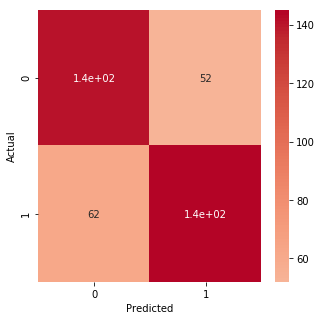

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#print(np.unique(featureset.iloc[:400,-1]))

#print(x_test)
predictions = search.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

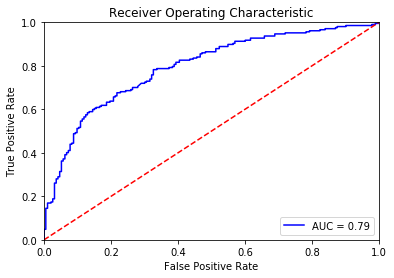

In [7]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = search.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

#Function for receiver operating charecteristics
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
import ftfy         #Preprocessing data
import re
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")  #regex for url


def preprocess(text):
    p_text = hashtag_re.sub("",text)
    p_text = mention_re.sub("",p_text)
    p_text = url_re.sub("",p_text)                 
    p_text = ftfy.fix_text(p_text)
    return p_text

import wikipedia #wikipedia api to retrieve docs or pages from server
from collections import Counter
query = input('Please enter your question: ').lower() #user query Enter a question
my_doc=nlp(query)
token_list = []    #Creating  token list
for token in my_doc:
    token_list.append(token.text)
sen=""
for word in token_list:
    if word.lower() not in question_words:   #reformulation of query like before
        sen=sen+word+" " 
query=sen
print(query)
pages=wikipedia.search(query, results=5)  #number of pages returned for user query here is 5, but can be changed accordingly
text=''
for page in pages:
    text=text+wikipedia.page(page).content
preprocessed_text=preprocess(text)
preprocessed_text=preprocessed_text.split("== References ==")[0] #removing garbage text after reference section
sent_tokens=nltk.sent_tokenize(preprocessed_text.lower())

print(len(sent_tokens))
bc = BertClient(check_length=False)   #bert client object please make sure the server is On {MUST}
for token in my_doc:
    token_list.append(token.text) 

q_vec=bc.encode(sent_tokens)
query_vec = bc.encode([query])[0]
bert_score = np.sum(query_vec * q_vec, axis=1) / np.linalg.norm(q_vec, axis=1)   #cosine score from bert sentence matrix
tfidf_cos1=[]
lav_dis1=[]
jac_sim1=[]
mscore1=[]
ham_dis1=[]  #**All variables and functions used here are similar like feature extraction from wikiqa for featrure extraction**
jwscore1=[]
sdscore1=[]
roscore1=[]
escore1=[]
wmd1=[]
ner_feature1=[]
common_keywords1=[]
count_noun_chunks1=[]
for context in sent_tokens:

    tfidf_cos=tfidf(query,context)
    tfidf_cos1.append(tfidf_cos)
    q_ner=list()
    doc1=nlp(sen)
    for ent in doc1.ents:
        q_ner.append(ent.text)
    
    doc2=nlp(context)
    ner_count=0
    for ent in doc2.ents:
        if ent.text in q_ner:
            ner_count=ner_count+1
    ner_feature1.append(ner_count)
    keycount=0
    rootq = [token for token in doc1 if token.head == token][0]
    keywordsq=[t.text for t in rootq.subtree if t.pos_=="NOUN" or t.pos_=="PROPN" or t.pos_=="VERB" or t.pos_=="NUM"]
    rootc = [token for token in doc2 if token.head == token][0]
    keywordsc=[t.text for t in rootc.subtree if t.pos_=="NOUN" or t.pos_=="PROPN" or t.pos_=="VERB" or t.pos_=="NUM"]
    for key in keywordsq:
        if key in keywordsc:
            keycount=keycount+1
    common_keywords1.append(keycount)
    ner_feature1.append(ner_count)
    q_noun_chunks=list(doc1.noun_chunks)
    c_noun_chunks=list(doc2.noun_chunks)
    count_chunks=0
    for chunk in c_noun_chunks:
        if chunk in q_noun_chunks:
            count_chunks=count_chunks+1
    count_noun_chunks1.append(count_chunks)
    #cosine.append(0)
    temp=glove_300.wmdistance(ques,context)
    if np.isnan(temp)==False:
        temp=0.0
    wmd1.append(temp)
    lav_dis1.append(nltk.edit_distance(ques,context))
    jac_sim1.append(jaccard_similarity(ques.split(),context.split()))
    #jscore=jaccard_similarity(question_vec,c_vec.flatten())
    mscore1.append(masi_distance(set(ques.split()),set(context.split())))
    ham_dis1.append(textdistance.hamming(ques, context))
    jwscore1.append(textdistance.jaro_winkler(ques,context))
    #Sorensen-Dice
    sdscore1.append(textdistance.sorensen(ques.split() , context.split()))
    #Ratcliff-Obershelp similarity
    roscore1.append(textdistance.ratcliff_obershelp(ques,context))
    escore1.append(textdistance.entropy_ncd(ques,context))


Please enter your question: where is california?
is california 
455


In [41]:
test_featureset = pd.DataFrame(list(zip(sent_tokens,bert_score,lav_dis1,jac_sim1,mscore1,ham_dis1,jwscore1,sdscore1,roscore1,escore1,ner_feature1,count_noun_chunks1,common_keywords1,wmd1,tfidf_cos1)), 
               columns =["Possible Answers","Cosine_Similarity","Levenshtein_distance","Jaccard_similarity","Masi_distance","Hamming_dustance","JaroWinkler_socre","Sorensen-Dice","Ratcliff-Obershelp_similarity","NCD_entropy","Common_NER","Common_noun_chunks","Common_Keywords","Word-Movers Distance","Tfidf_Cosine_Similarity"])
#print(test_featureset)

In [38]:
predictions = search.predict(test_featureset.iloc[:,1:])
print(predictions) #predicted data

[0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0]


In [40]:
from sklearn.preprocessing import MinMaxScaler
predicted_answers=test_featureset.iloc[np.where(predictions==1)[0].flatten()] #using indices of predicted answers
#print(predicted_answers)
normalized_scores=MinMaxScaler().fit_transform(predicted_answers.iloc[:,1:]) #|MInMAx scalar used here for feature data normalisation
#print(np.shape(normalized_scores)[1])
sum=0
#print(predicted_answers)
for i in range(0,np.shape(normalized_scores)[1]):      #sum of all normalized scores
    sum=sum+normalized_scores[:,i]
#print(sum)
#common NER and common noun chunks will have a slight priority
sum=sum-predicted_answers.iloc[:,10].values-predicted_answers.iloc[:,11].values
#print(sum)
answer_index=sum.argsort()[:5]
print(answer_index)
best_answer=predicted_answers.iloc[answer_index,0]
print(best_answer.values.tolist())  #Top 5 answers returned

[31 46 63 87 58]
["a majority of california's cities are located in either the san francisco bay area or the sacramento metropolitan area in northern california; or the los angeles area, the riverside-san bernardino-inland empire, or the san diego metropolitan area in southern california.", '=== national origins ===\naccording to the united states census bureau in 2018 the population self-identifies as (alone or in combination):\n72.1% white (including hispanic whites)\n15.3% asian\n6.5% black or african american\n1.6% native american and alaska native\n0.5% native hawaiian or pacific islander\n3.9% two or more racesby ethnicity, in 2018 the population was 60.7% non-hispanic (of any race) and 39.3% hispanic or latino (of any race).', "while proposition 30 also enacted a minimum state sales tax of 7.5%, this sales tax increase was not extended by proposition 55 and reverted to a previous minimum state sales tax rate of 7.25% in 2017. local governments can and do levy additional sales ta